In [1]:
import os

import scipy.ndimage as ndimage
from importlib import reload

import tifffile as tf
import numpy as np
import pandas as pd

import arabidopsis_utils as thales

In [125]:
reload(thales)

<module 'arabidopsis_utils' from '/home/ejam/documents/arabidopsis_scanning/jupyter/arabidopsis_utils.py'>

In [162]:
tiff_file = '../raw3d/col-0.tif'
pot_dst = '../pots/'
norm_src = '../normalization/vals/'

src, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]
img = tf.imread(tiff_file)

In [163]:
dst = pot_dst + bname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
print('All results will be saved in ', dst)

All results will be saved in  ../pots/col-0/


## Standardize the density values

Load the coefficients $a,b,c$ of the polynomial adjustment as computed before. 

For each voxel with density value $\rho\in\{0,1,\ldots,255\}$, we compute $f(\rho)=a\rho+b$.

We then normalize the density values as
$$ g(\rho) = \begin{cases}
255, &\text{if }\; f(\rho) > 255,\\
f(\rho), &\text{if }\; 0\leq f(\rho)\leq 255,\\
0, &\text{if }\; f(\rho)<0.
\end{cases} $$

In [44]:
adjust_by = np.loadtxt(norm_src + bname+'_coefs.csv', dtype='float', delimiter=',')
print('Polynomials coefficients,\t', adjust_by)

if bname != 'col-0':
    img = thales.normalize_density(img, adjust_by)

Polynomials coefficients,	 [0. 1.]


## Remove slices that are purely air

In [132]:
avgs = np.mean(img, axis=(1,2))
maxs = np.max(img, axis=(1,2))
mins = np.min(img, axis=(1,2))
diff = maxs - mins

min_height = 200
upcutoff = np.nonzero(diff[min_height:] < 6)[0][0] + min_height
dwcutoff = np.nonzero(diff == np.max(diff))[0][-1]
if dwcutoff > upcutoff - 10:
    dwcutoff = 0

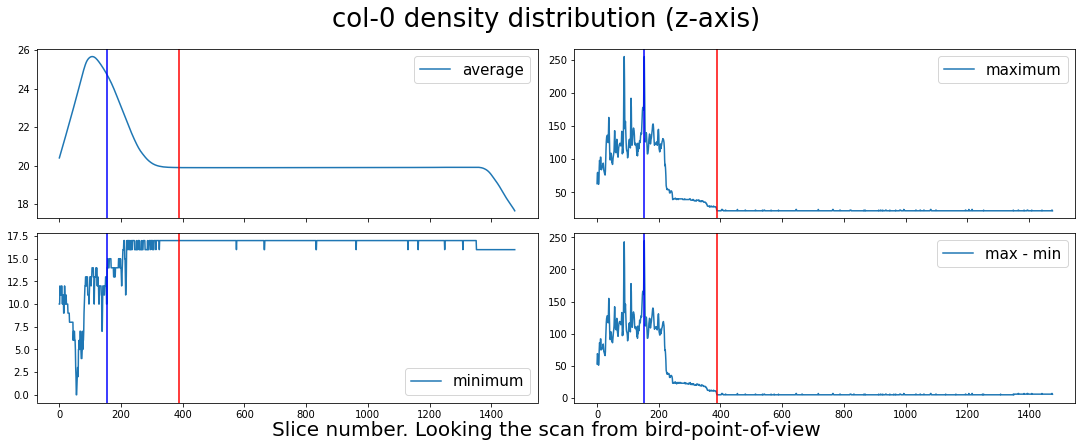

In [133]:
fig, ax = plt.subplots(2,2, figsize=(15,6), sharex=True)
xrange = np.arange(len(avgs), dtype=np.uint16)
ax[0,0].plot(xrange, avgs, label = 'average');
ax[0,1].plot(xrange, maxs, label = 'maximum');
ax[1,0].plot(xrange, mins, label = 'minimum');
ax[1,1].plot(xrange, diff, label = 'max - min');

fig.suptitle(bname + ' density distribution (z-axis)', fontsize=26)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].legend(fontsize=15)
        ax[i,j].axvline(x=upcutoff, c='r')
        ax[i,j].axvline(x=dwcutoff, c='b')
        
fig.text(0.5,0.0, "Slice number. Looking the scan from bird-point-of-view", ha="center", va="center", fontsize=20)
fig.tight_layout()

In [141]:
img = img[dwcutoff:upcutoff, : ,:]

## Remove air: Gaussian blurring and thresholding

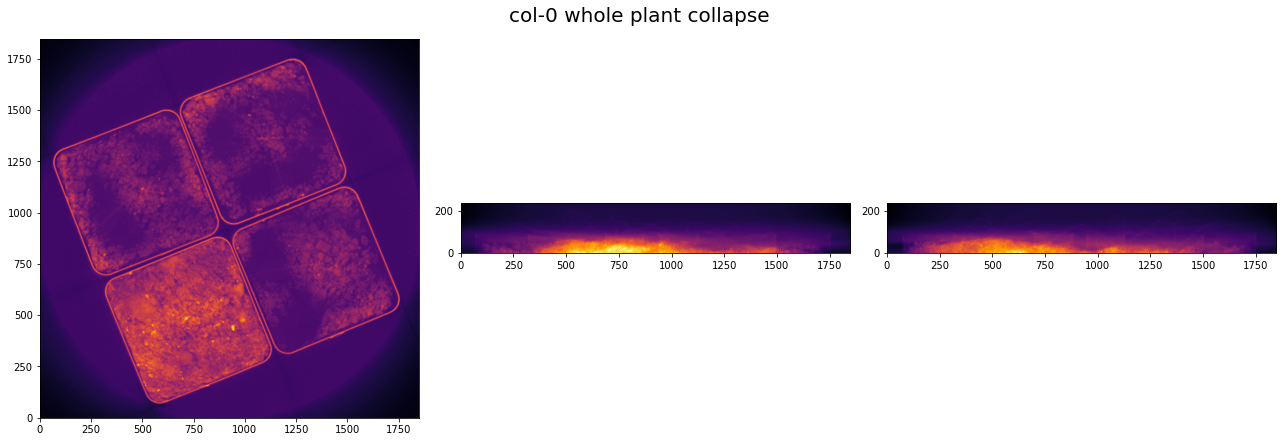

In [142]:
snaps = thales.collapse_dimensions(img)
thales.plot_collapse_dimensions(snaps, bname, 'whole plant')

[(inf, None, 19), (3565182, 29, 34), (79, 116, 118), (66, 113, 115), (43, 100, 101), (12, 127, 128), (11, 139, 140), (8, 125, 126), (7, 136, 137), (6, 176, 181), (6, 173, 174), (5, 182, 198), (5, 156, 162), (5, 148, 150), (4, 202, 240), (4, 194, 193), (4, 192, 190), (4, 178, 177), (3, 220, 219), (3, 210, 208), (3, 206, 204), (3, 164, 170), (3, 132, 133), (2, 243, 254), (2, 237, 236), (2, 232, 231), (2, 216, 215), (2, 213, 212), (2, 200, 201), (2, 196, 195), (2, 187, 186), (2, 153, 154), (1, 251, 250), (1, 228, 227), (1, 224, 223), (1, 218, 217), (1, 189, 188), (1, 171, 172), (1, 167, 166), (1, 159, 158), (1, 151, 152), (0, 241, 242), (0, 143, 144)]
32


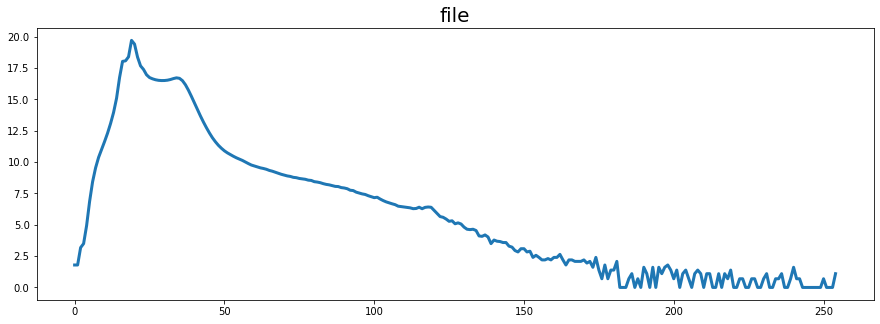

In [48]:
thr = thales.get_individual_threshold(img, True)
print(thr)

In [143]:
sigma = 3
avg = ndimage.gaussian_filter(img, sigma=sigma, mode='mirror', truncate=3, cval=0)

[(inf, None, 18), (30935656, 16, 15), (9164475, 20, 21), (5223073, 25, 30), (25, 87, 88), (23, 99, 100), (18, 103, 105), (17, 91, 93), (12, 96, 97), (9, 101, 102), (7, 89, 90), (1, 107, 108), (0, 112, 254)]
17


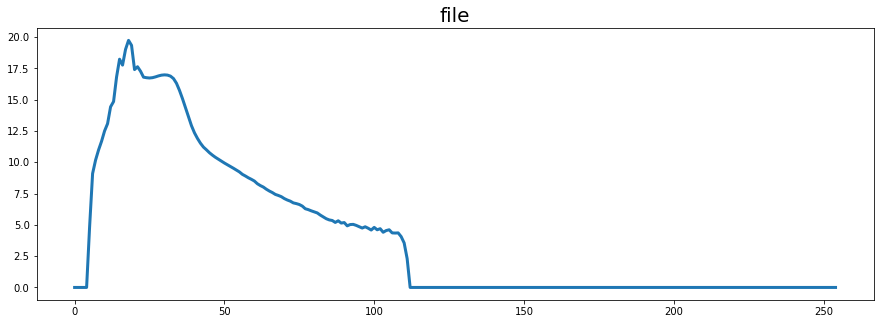

In [51]:
thr = thales.get_individual_threshold(avg, True)
print(thr)

In [144]:
thr = 40
timg = img.copy()
timg[avg < 22] = 0
#timg[avg > 35] = 0

2 2


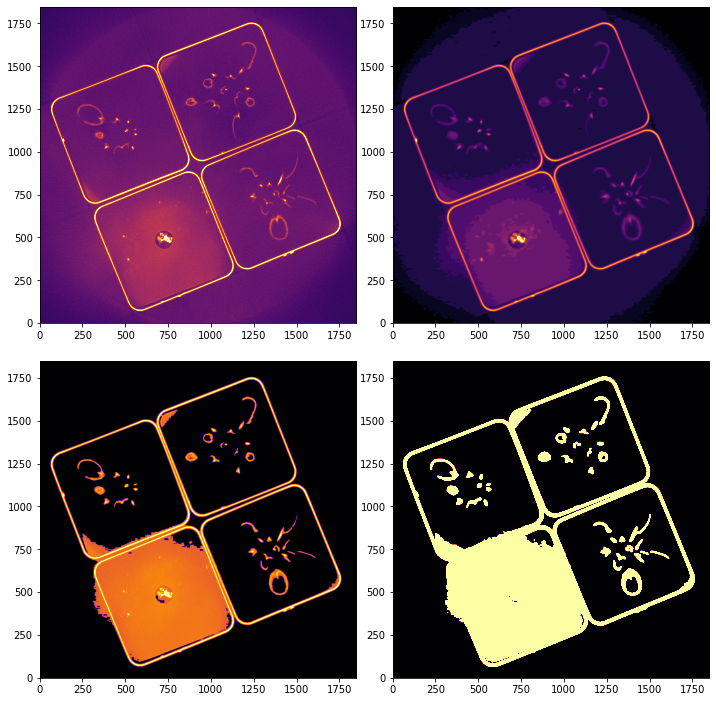

In [147]:
k = 75
ss = np.s_[k,:,:]

thales.plot4x4panel([img, avg, timg, timg], ss, vmax=[35,35,35,1])

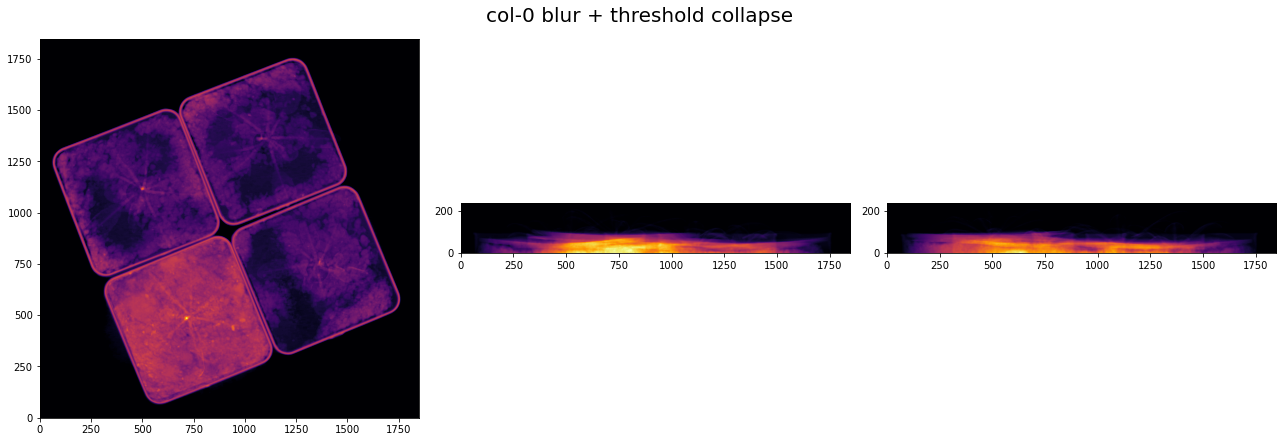

In [148]:
snaps = thales.collapse_dimensions(timg)
thales.plot_collapse_dimensions(snaps, bname, 'blur + threshold')

## Remove soil: Aggressive opening

Most likely only soil will remain.

In [149]:
binimg = timg.copy()
binimg[binimg > 0] = 1

In [150]:
strucx = ndimage.generate_binary_structure(img.ndim, 1)
strucx[1,:,:] = True
strucx

array([[[False, False, False],
        [False,  True, False],
        [False, False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False, False, False],
        [False,  True, False],
        [False, False, False]]])

In [151]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
erode = ndimage.binary_erosion(binimg, structure=strucx, iterations = 12)

In [152]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
dilate = ndimage.binary_dilation(erode, structure=strucx, iterations = 12)

In [153]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
erode2 = ndimage.binary_erosion(dilate, structure=strucx, iterations = 12)

In [154]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
dilate2 = ndimage.binary_dilation(erode2, structure=strucx, iterations = 15)

In [155]:
soilless = timg*~dilate2

2 2


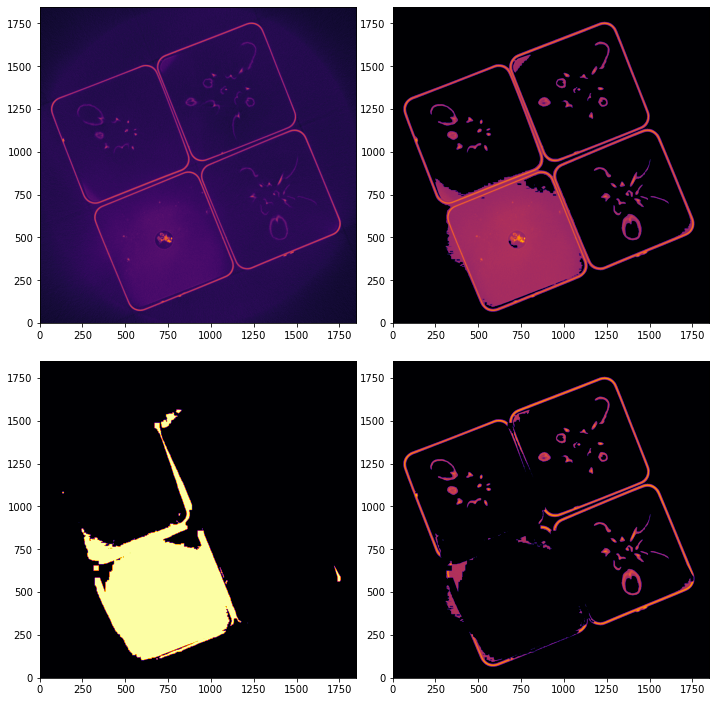

In [160]:
k = 75
ss = np.s_[k,:,:]

thales.plot4x4panel([img, timg, dilate2, soilless], ss)#, vmax=[150,150,150,150])

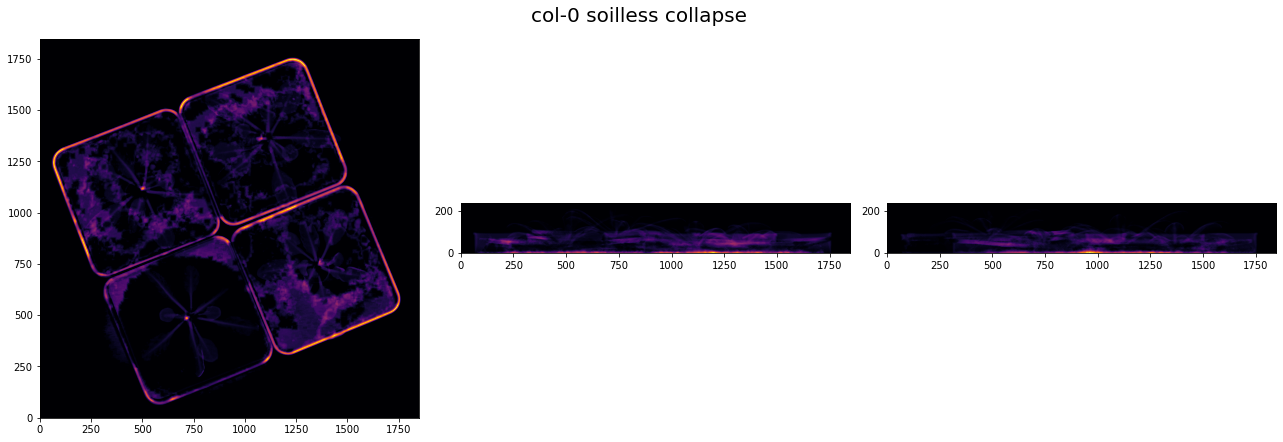

In [159]:
snaps = thales.collapse_dimensions(soilless)
thales.plot_collapse_dimensions(snaps, bname, 'soilless')

[(inf, None, 22), (55279, 29, 34), (32, 76, 78), (26, 83, 84), (17, 74, 75), (15, 92, 93), (13, 88, 89), (8, 80, 82), (7, 63, 64), (6, 107, 110), (5, 122, 123), (5, 105, 106), (4, 134, 161), (4, 129, 130), (4, 118, 119), (4, 102, 103), (4, 98, 99), (4, 96, 97), (3, 210, 208), (3, 199, 198), (3, 194, 193), (3, 182, 181), (3, 175, 240), (3, 155, 151), (3, 139, 138), (3, 116, 117), (3, 68, 69), (3, 60, 61), (2, 202, 201), (2, 191, 190), (2, 178, 177), (2, 165, 164), (2, 162, 167), (2, 159, 158), (2, 150, 149), (2, 141, 140), (2, 131, 132), (2, 124, 127), (1, 243, 242), (1, 241, 254), (1, 237, 236), (1, 235, 234), (1, 227, 226), (1, 220, 219), (1, 212, 211), (1, 206, 205), (1, 187, 186), (1, 171, 170), (1, 168, 173), (1, 157, 156), (1, 144, 143), (1, 137, 136), (1, 126, 125), (1, 120, 121), (1, 112, 113), (1, 71, 72), (1, 11, 10), (0, 152, 153), (0, 114, 115)]
30


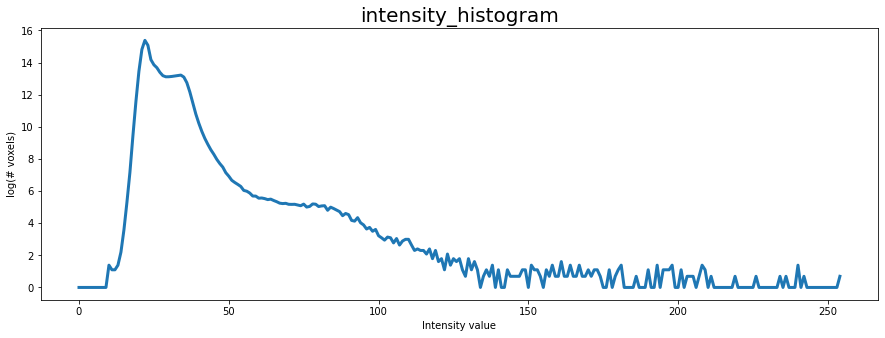

In [158]:
thr = thales.get_individual_threshold(soilless, True)
print(thr)

In [164]:
tf.imwrite(dst + 'airless.tif', timg, photometric='minisblack',compress=3)
tf.imwrite(dst + 'soilless.tif', soilless, photometric='minisblack', compress=3)